# Importing Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_curve,auc
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV

# Importing The Dataset

In [2]:
df = pd.read_csv('data_1.csv')

# Splitting the dataset

In [3]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
y = label_binarize(y,classes=[1,2,3])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

# Classifying using DecisionTreeClassifier

In [4]:
def compute_metrics(model):
  y_pred = model.predict(X_test)
  print("Accuracy ",accuracy_score(y_test,y_pred))
  print("Precision ", precision_score(y_test,y_pred,average='micro'))
  print("Recall ",recall_score(y_test,y_pred,average='micro'))
  print("Depth ",model.get_depth())

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(3):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(3):
      plt.plot(fpr[i], tpr[i],label='ROC curve of class {0} (area = {1:0.2f})'.format(i+1, roc_auc[i]))

  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('AUC-ROC Curve')
  plt.legend()
  plt.show()

In [5]:
decision_tree = DecisionTreeClassifier(random_state=0,criterion="entropy")
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Accuracy  0.9655172413793104
Precision  0.9655172413793104
Recall  0.9655172413793104
Depth  14


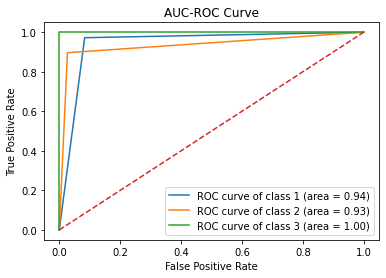

In [6]:
compute_metrics(decision_tree)

# Cost Complexity Pruning

In [7]:
path = decision_tree.cost_complexity_pruning_path(X_train,y_train)

In [8]:
path['ccp_alphas'] = path['ccp_alphas'][:-1]
path['impurities'] = path['impurities'][:-1]

In [9]:
path

{'ccp_alphas': array([0.        , 0.00114943, 0.00158327, 0.00158327, 0.00158327,
        0.001629  , 0.00166953, 0.00172414, 0.00186501, 0.00186501,
        0.0018959 , 0.00224146, 0.00231234, 0.00233789, 0.00265997,
        0.00285391, 0.0028848 , 0.00308045, 0.00312012, 0.00326925,
        0.00330446, 0.00368961, 0.00407262, 0.0043762 , 0.00472348,
        0.00564125, 0.0062952 , 0.00673869, 0.00740288, 0.01583594,
        0.01894564, 0.02208928, 0.03098088]),
 'impurities': array([0.        , 0.00114943, 0.00273269, 0.00431596, 0.00589923,
        0.00752824, 0.00919776, 0.01264604, 0.01451105, 0.01637605,
        0.01827195, 0.02051341, 0.02282575, 0.02516364, 0.02782361,
        0.03067752, 0.03356232, 0.03972323, 0.04284335, 0.05265111,
        0.06586895, 0.06955856, 0.07363118, 0.07800738, 0.08273085,
        0.08837211, 0.10725772, 0.11399641, 0.12139929, 0.13723523,
        0.17512651, 0.19721579, 0.25917754])}

In [10]:
accuracy_train = []
accuracy_test = []

In [11]:
max_test_accuracy = 0.0
alpha = 0.0

In [12]:
for i in path['ccp_alphas']:
  dtree = DecisionTreeClassifier(random_state=0,criterion="entropy",ccp_alpha=i)
  dtree.fit(X_train,y_train)
  y_pred = dtree.predict(X_test)
  y_pred_train = dtree.predict(X_train)
  accuracy_test.append(accuracy_score(y_test,y_pred))
  accuracy_train.append(accuracy_score(y_train,y_pred_train))
  if accuracy_test[-1]>max_test_accuracy:
    max_test_accuracy = accuracy_test[-1]
    alpha=i

In [13]:
max_test_accuracy

0.9689655172413794

In [14]:
alpha

0.0015832686794042922

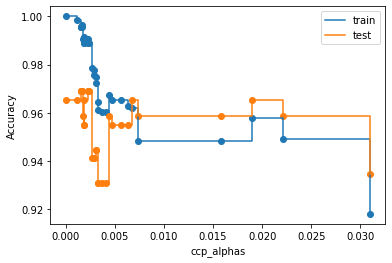

In [15]:
plt.scatter(path['ccp_alphas'],accuracy_train)
plt.scatter(path['ccp_alphas'],accuracy_test)
plt.plot(path['ccp_alphas'],accuracy_train,label='train',drawstyle='steps-post')
plt.plot(path['ccp_alphas'],accuracy_test,label='test',drawstyle='steps-post')
plt.legend()
plt.xlabel("ccp_alphas")
plt.ylabel("Accuracy")
plt.show()

Accuracy  0.9689655172413794
Precision  0.9689655172413794
Recall  0.9689655172413794
Depth  14


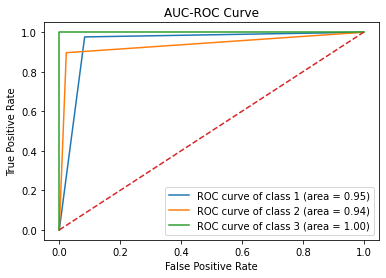

In [16]:
decision_tree_with_cc_pruning = DecisionTreeClassifier(random_state=0,criterion="entropy",ccp_alpha=0.0015832686794042922)
decision_tree_with_cc_pruning.fit(X_train,y_train)
compute_metrics(decision_tree_with_cc_pruning)

In [17]:
fig = plt.figure(figsize=(200,200))
_ = plot_tree(decision_tree_with_cc_pruning,feature_names=df.columns[:-1],filled=True)
fig.savefig("DT_B_2_CC.png")

Output hidden; open in https://colab.research.google.com to view.

# Pre Pruning

In [18]:
params = {'max_depth': [2,4,6,8,10],
          'min_samples_split': [2,3,4,5],
          'min_samples_leaf': [1,2,3,4,5,6]}

In [19]:
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0,criterion='entropy'),param_grid=params)
grid_search.fit(X_train,y_train)
print("Best Params: ",grid_search.best_params_)
decision_tree_with_pre_pruning = grid_search.best_estimator_

Best Params:  {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


Accuracy  0.9655172413793104
Precision  0.9655172413793104
Recall  0.9655172413793104
Depth  4


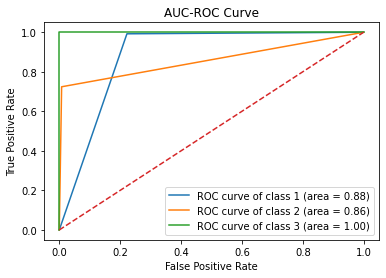

In [20]:
decision_tree_with_pre_pruning.fit(X_train,y_train)
compute_metrics(decision_tree_with_pre_pruning)

In [21]:
fig = plt.figure(figsize=(200,200))
_ = plot_tree(decision_tree_with_pre_pruning,feature_names=df.columns[:-1],filled=True)
fig.savefig("DT_B_2_XX.png")